In [97]:
import matplotlib.pyplot as plt
import numpy.random
import numpy as np
import seaborn
import sklearn as sk
import pandas as pd
import glob
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Defining Functions and Figure Output Preferences

In [207]:
pylab.rcParams['figure.figsize'] = (8, 4)
pylab.rcParams['xtick.labelsize'] = 16
pylab.rcParams['ytick.labelsize'] = 16
pylab.rcParams['axes.labelsize'] = 15
pylab.rcParams['legend.fontsize'] = 15
pylab.rcParams['axes.titlesize'] = 17
pylab.rcParams['legend.frameon'] = True 
# pylab.rcParams['figure.'] = True 

def listOfFiles(path):
    itemAll=[]
    for item in os.listdir(path):
        if not item.startswith('.') and os.path.isfile(os.path.join(path, item)):
            itemAll.append(item)
    return itemAll
def leastSquareErr(Y,YHat):
    Err=0
    for x in xrange(len(Y)):
        Err+=((Y[x]-YHat[x]))**2
    return Err
def obtainRows(Val,M):
    List=[]
    for i in xrange(len(M)):
        if Val[0]==M[i,0] and Val[1]==M[i,1]:
            List.append(M[i,:])
    ret=np.array(List)
    ret.sort(axis=0)
    return ret
            

## Importing Data/ Parsing Files

In [134]:
path='Data/' #path to data folder
dirs = [d for d in os.listdir('Data/') if os.path.isdir(os.path.join('Data/', d))] #Getting names of directories
try: del dataKAll
except: pass
try: del dataPAll
except: pass
    
for dirr in dirs:
    fileListAll=listOfFiles(path+dirr)
    for filer in fileListAll:
        ff=filer.split('.')[0] #get rit of .out
        PVK=ff.split('-')[1] # obtain file type from the file name
        
        if PVK=='PV' or PVK=='VK': #Check to see what file type it is
            data = np.loadtxt(path+dirr+'/'+filer, delimiter=' ')
            H=float(ff.split('H')[1].split('T')[0])+data[:,0]*0.
            T=float(ff.split('T')[1].split('-')[0])+data[:,0]*0.
            
            if PVK=='PV': #file PV: col0 V; col1 P
                V=data[:,0]
                P=data[:,1]
                dataAll=np.column_stack((H,T,V,P))
                try: dataPAll=np.vstack((dataPAll,dataAll))
                except: dataPAll=dataAll
                
            if PVK=='VK': #file VK: col0 K; col1 V
                V=data[:,1]
                K=data[:,0]
                dataAll=np.column_stack((H,T,V,K))
                try: dataKAll=np.vstack((dataKAll,dataAll))
                except: dataKAll=dataAll


np.random.shuffle(dataKAll)
np.random.shuffle(dataPAll)

XK=dataKAll[:,:-1]
YK=dataKAll[:,-1]
XP=dataPAll[:,:-1]
YP=dataPAll[:,-1]

## Neural Networks Learning Algorithm

In [219]:
from sklearn.neural_network import MLPRegressor
MLP=MLPRegressor(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001, batch_size='auto',
     learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
     shuffle=True, random_state=None, tol=0.0001, verbose=False, 
     warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
     validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

TrainL=int(len(YP)*9./10.)

XTrain=XP[:TrainL,:]
YTrain=YP[:TrainL]
XTest=XP[TrainL:,:]
YTest=YP[TrainL:]

MLP.fit(XTrain,YTrain)

YKHat=MLP.predict(XTest)
print MLP.score(XTest,YTest)


0.590243412699


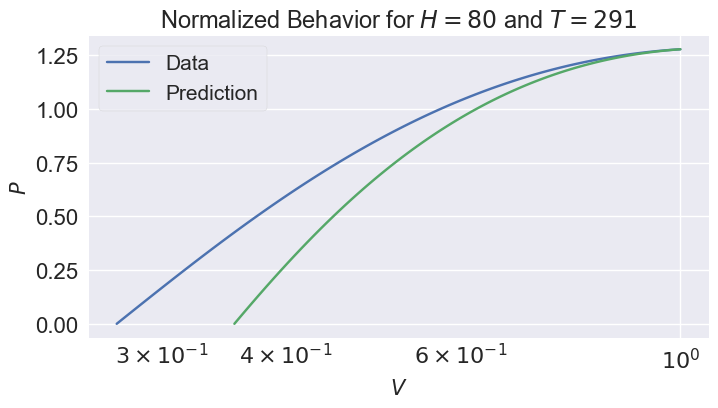

In [220]:
# Testing Plot with PV
#Filtering
H=80;T=291
rawData = obtainRows([H,T],dataPAll)
V=rawData[:,2]
P=rawData[:,3]
P_predict=rawData[:,:-1]
V_predict=MLP.predict(P_predict)

plt.title(r'Normalized Behavior for $H=80$ and $T=291$')
plt.xlabel(r'$V$')
plt.ylabel(r'$P$')
plt.semilogx(V/max(V),P,label='Data')
plt.semilogx(V_predict/max(V_predict),P,label='Prediction')
plt.legend()

In [199]:
print V_predict
print V

[ 0.44637797  0.44717374  0.44796951  0.44916316  0.45095364  0.45363934
  0.45766791  0.46371076  0.47166844  0.47962612  0.48758376  0.49554144
  0.50349909  0.51145677  0.51941445  0.5273721   0.53532978  0.54328745
  0.5512451   0.55920278  0.56716046  0.57511814  0.58307579  0.59103347
  0.59899111  0.60694879  0.61490647  0.62286412  0.6308218   0.63877948
  0.64673713  0.6546948   0.66265248  0.67061016  0.67856778  0.68652546
  0.69448314  0.70244082  0.71039849  0.71835617  0.72631379  0.73427147
  0.74222915  0.75018683  0.7581445   0.76610212  0.7740598   0.78201748
  0.78997516  0.79793284  0.80589052  0.81384814  0.82180581  0.82976349
  0.83772117  0.84567885  0.85363647  0.86159415  0.86955183  0.8775095
  0.88546718  0.89342486  0.90138248  0.90934016  0.91729784  0.92525551
  0.93321319  0.94117081  0.94912849  0.95708617  0.96504385  0.97300153
  0.9809592   0.98891682  0.9968745   1.00483218  1.01278986  1.02074754
  1.02870516  1.03666283  1.04462051  1.05257819  1.

In [180]:
x

[[  8.00000000e+01   2.91000000e+02   4.93127246e+03   0.00000000e+00]
 [  8.00000000e+01   2.91000000e+02   4.94458691e+03   4.33976203e-03]
 [  8.00000000e+01   2.91000000e+02   4.95790137e+03   8.66723340e-03]
 [  8.00000000e+01   2.91000000e+02   4.97787305e+03   1.51353963e-02]
 [  8.00000000e+01   2.91000000e+02   5.00783057e+03   2.47858576e-02]
 [  8.00000000e+01   2.91000000e+02   5.05276660e+03   3.91452089e-02]
 [  8.00000000e+01   2.91000000e+02   5.12017090e+03   6.04231097e-02]
 [  8.00000000e+01   2.91000000e+02   5.22127734e+03   9.17526260e-02]
 [  8.00000000e+01   2.91000000e+02   5.35442188e+03   1.31945267e-01]
 [  8.00000000e+01   2.91000000e+02   5.48756641e+03   1.70939073e-01]
 [  8.00000000e+01   2.91000000e+02   5.62071045e+03   2.08750293e-01]
 [  8.00000000e+01   2.91000000e+02   5.75385498e+03   2.45398208e-01]
 [  8.00000000e+01   2.91000000e+02   5.88699902e+03   2.80904800e-01]
 [  8.00000000e+01   2.91000000e+02   6.02014355e+03   3.15294385e-01]
 [  8.

In [180]:
x

[[  8.00000000e+01   2.91000000e+02   4.93127246e+03   0.00000000e+00]
 [  8.00000000e+01   2.91000000e+02   4.94458691e+03   4.33976203e-03]
 [  8.00000000e+01   2.91000000e+02   4.95790137e+03   8.66723340e-03]
 [  8.00000000e+01   2.91000000e+02   4.97787305e+03   1.51353963e-02]
 [  8.00000000e+01   2.91000000e+02   5.00783057e+03   2.47858576e-02]
 [  8.00000000e+01   2.91000000e+02   5.05276660e+03   3.91452089e-02]
 [  8.00000000e+01   2.91000000e+02   5.12017090e+03   6.04231097e-02]
 [  8.00000000e+01   2.91000000e+02   5.22127734e+03   9.17526260e-02]
 [  8.00000000e+01   2.91000000e+02   5.35442188e+03   1.31945267e-01]
 [  8.00000000e+01   2.91000000e+02   5.48756641e+03   1.70939073e-01]
 [  8.00000000e+01   2.91000000e+02   5.62071045e+03   2.08750293e-01]
 [  8.00000000e+01   2.91000000e+02   5.75385498e+03   2.45398208e-01]
 [  8.00000000e+01   2.91000000e+02   5.88699902e+03   2.80904800e-01]
 [  8.00000000e+01   2.91000000e+02   6.02014355e+03   3.15294385e-01]
 [  8.

In [180]:
x

[[  8.00000000e+01   2.91000000e+02   4.93127246e+03   0.00000000e+00]
 [  8.00000000e+01   2.91000000e+02   4.94458691e+03   4.33976203e-03]
 [  8.00000000e+01   2.91000000e+02   4.95790137e+03   8.66723340e-03]
 [  8.00000000e+01   2.91000000e+02   4.97787305e+03   1.51353963e-02]
 [  8.00000000e+01   2.91000000e+02   5.00783057e+03   2.47858576e-02]
 [  8.00000000e+01   2.91000000e+02   5.05276660e+03   3.91452089e-02]
 [  8.00000000e+01   2.91000000e+02   5.12017090e+03   6.04231097e-02]
 [  8.00000000e+01   2.91000000e+02   5.22127734e+03   9.17526260e-02]
 [  8.00000000e+01   2.91000000e+02   5.35442188e+03   1.31945267e-01]
 [  8.00000000e+01   2.91000000e+02   5.48756641e+03   1.70939073e-01]
 [  8.00000000e+01   2.91000000e+02   5.62071045e+03   2.08750293e-01]
 [  8.00000000e+01   2.91000000e+02   5.75385498e+03   2.45398208e-01]
 [  8.00000000e+01   2.91000000e+02   5.88699902e+03   2.80904800e-01]
 [  8.00000000e+01   2.91000000e+02   6.02014355e+03   3.15294385e-01]
 [  8.